In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
                        
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [57]:
df = pd.read_csv('COMED_hourly.csv')

# **1. Data Visualization**

In [58]:
df.head()

,Datetime,COMED_MW
0,12/31/02 1:00,26498
1,12/31/02 2:00,25147
2,12/31/02 3:00,24574
3,12/31/02 4:00,24393
4,12/31/02 5:00,24860


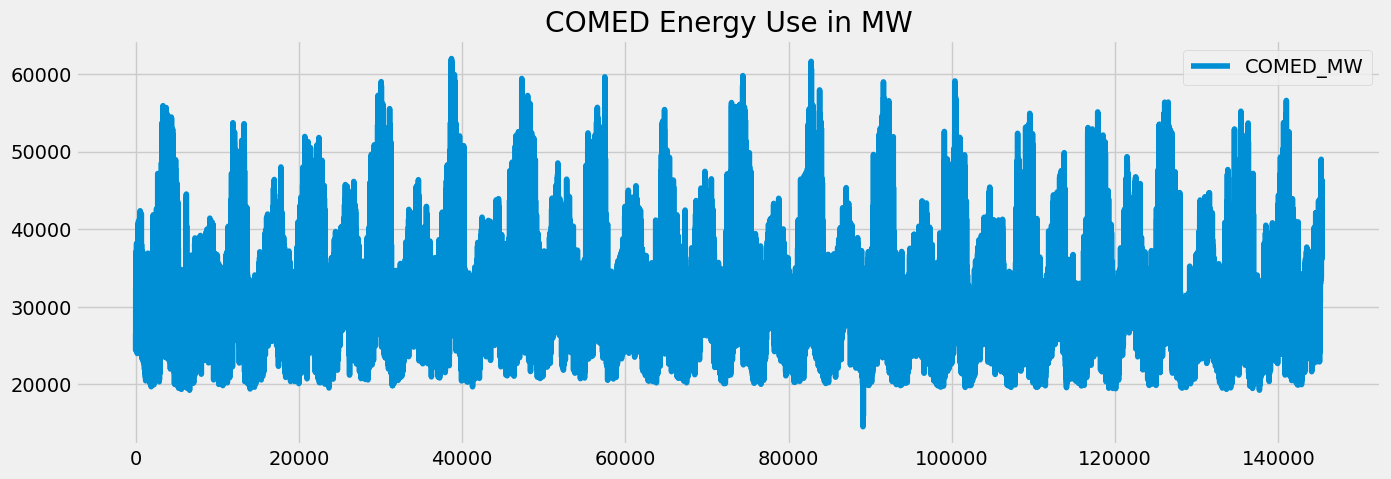

In [59]:
df.plot(#style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='COMED Energy Use in MW')
plt.show()

# **2. Data Preprocessing**

Since this is a TimeSeries problem, we have to parse the 'datetime' column

In [60]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

/tmp/ipykernel_208807/3818658747.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


,COMED_MW
Datetime,
2002-12-31 01:00:00,26498
2002-12-31 02:00:00,25147
2002-12-31 03:00:00,24574
2002-12-31 04:00:00,24393
2002-12-31 05:00:00,24860


## 2.1 Handle Missings

In [61]:
df.isna().sum()

COMED_MW    0
dtype: int64

## 2.2 Handle Outliers

<Axes: ylabel='Frequency'>

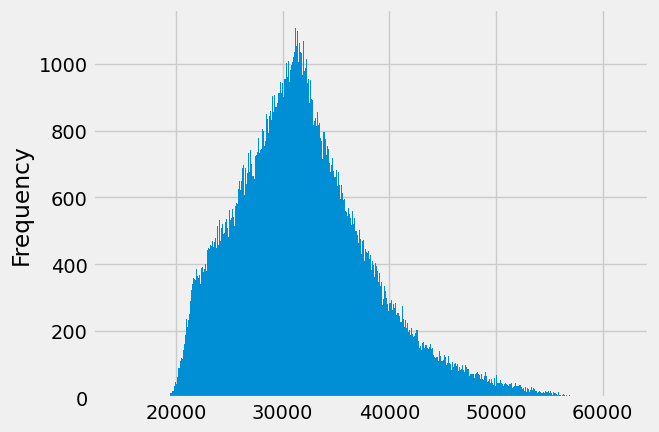

In [62]:
df['COMED_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

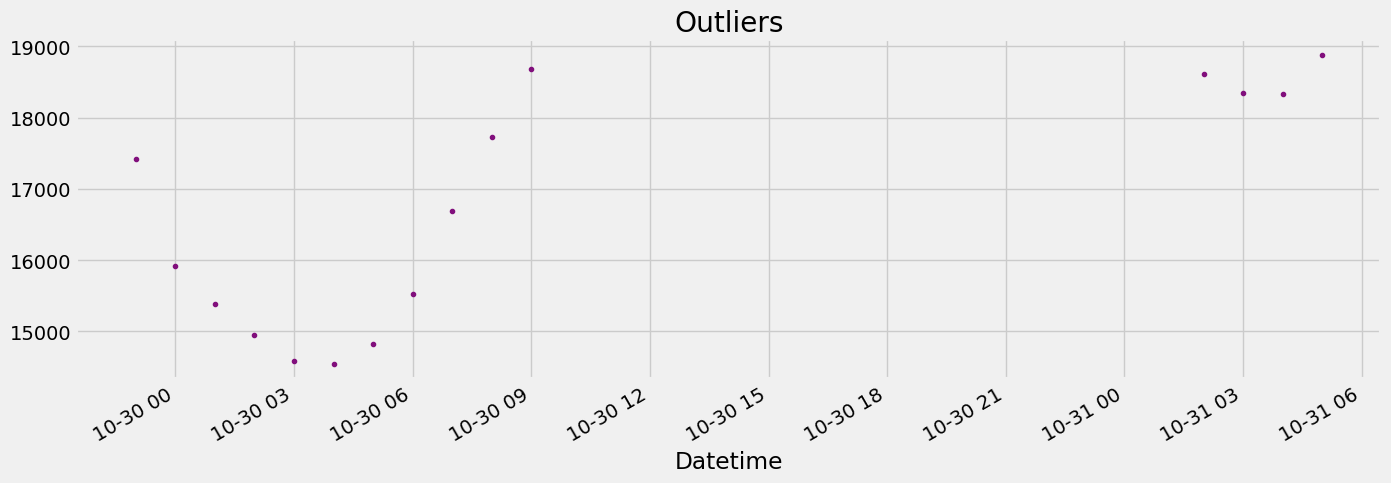

In [63]:
df.query('COMED_MW < 19_000')['COMED_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [64]:
df = df.query('COMED_MW > 19_000').copy()

# **3. Feature Engineering**

In [65]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['season'] = df['month'] % 12 // 3 + 1
    return df

season_names = {
    1: "Winter",
    2: "Spring",
    3: "Summer",
    4: "Fall"
}

df = create_features(df)
df['season'] = df['season'].map(season_names)
df.head()

,COMED_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498,1,1,4,12,2002,365,31,1,Winter
2002-12-31 02:00:00,25147,2,1,4,12,2002,365,31,1,Winter
2002-12-31 03:00:00,24574,3,1,4,12,2002,365,31,1,Winter
2002-12-31 04:00:00,24393,4,1,4,12,2002,365,31,1,Winter
2002-12-31 05:00:00,24860,5,1,4,12,2002,365,31,1,Winter


# **4. Exploratory Data Analysis**

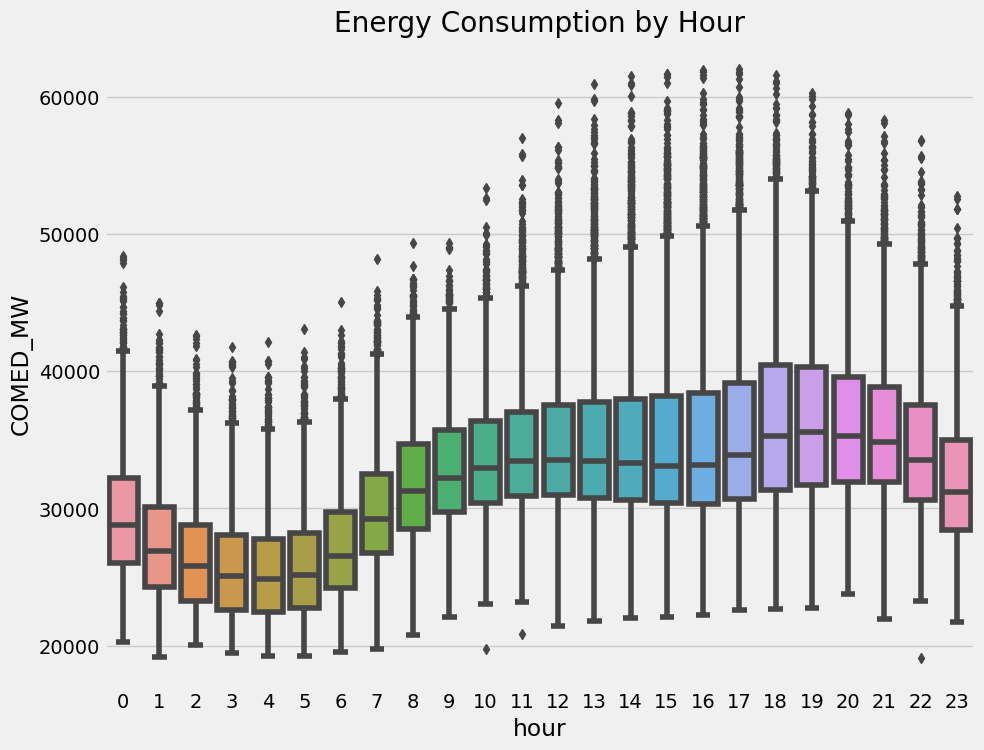

In [66]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='COMED_MW')
ax.set_title('Energy Consumption by Hour')
plt.show()

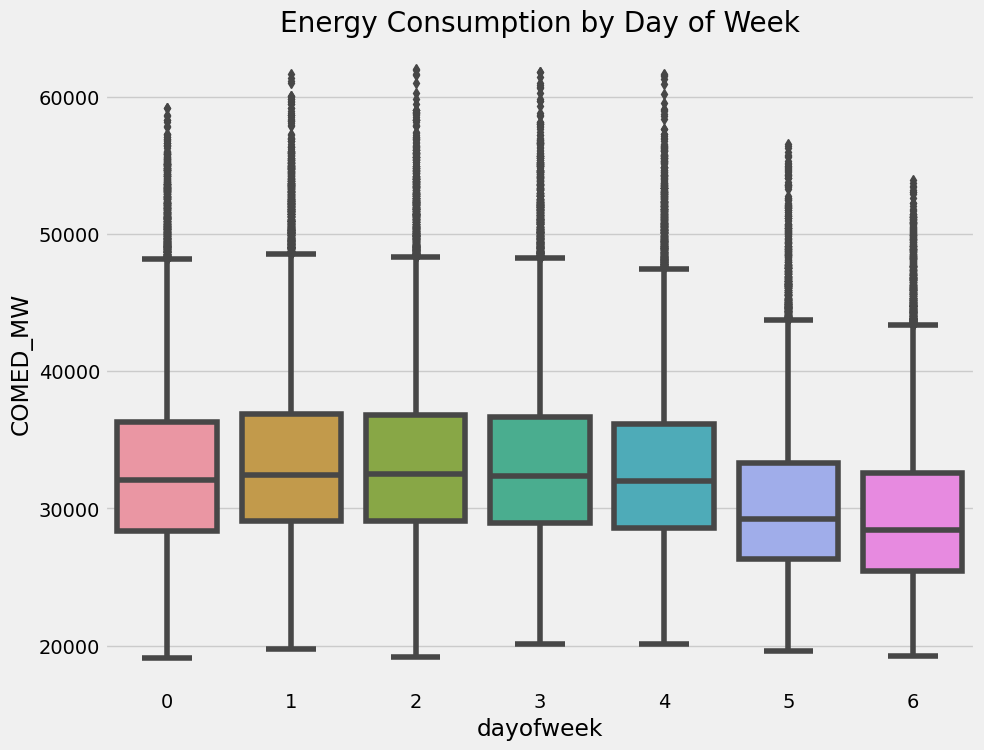

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='COMED_MW')
ax.set_title('Energy Consumption by Day of Week')
plt.show()

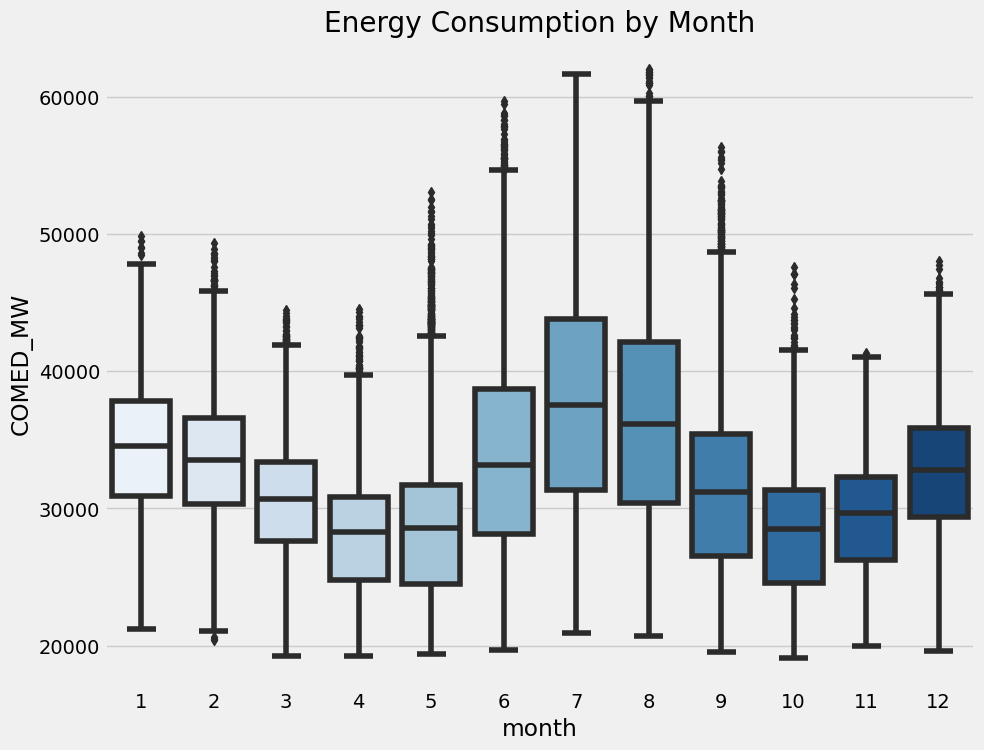

In [68]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='COMED_MW', palette='Blues')
ax.set_title('Energy Consumption by Month')
plt.show()

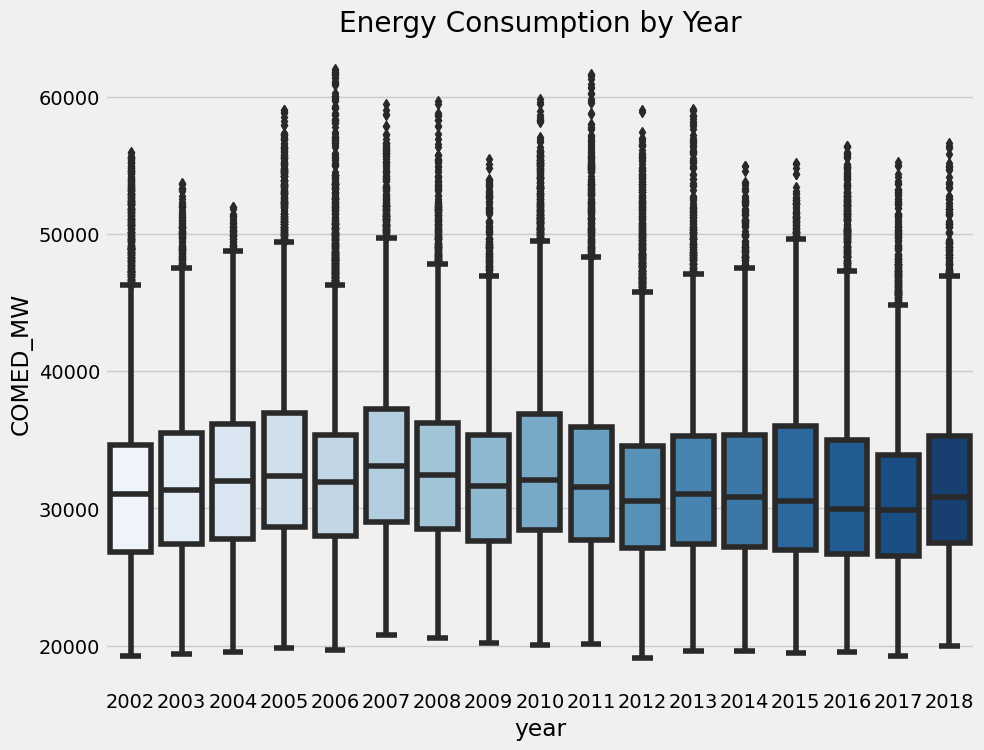

In [69]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='COMED_MW', palette='Blues')
ax.set_title('Energy Consumption by Year')
plt.show()

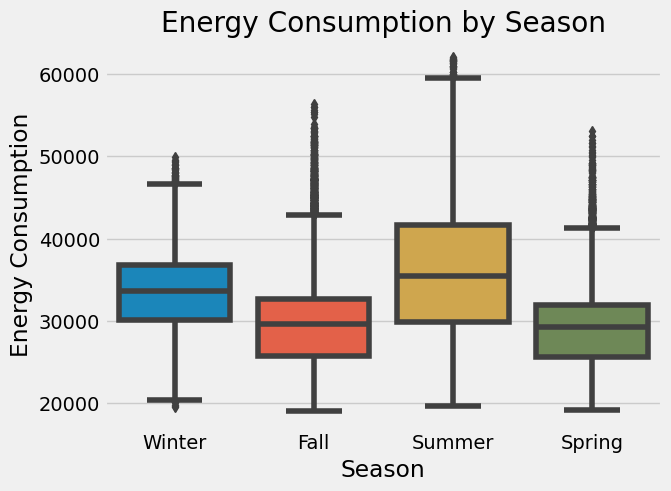

In [70]:
# Create a boxplot of energy consumption by season
sns.boxplot(x="season", y="COMED_MW", data=df)

# Set the plot title and axis labels
plt.title("Energy Consumption by Season")
plt.xlabel("Season")
plt.ylabel("Energy Consumption")

# Display the plot
plt.show()

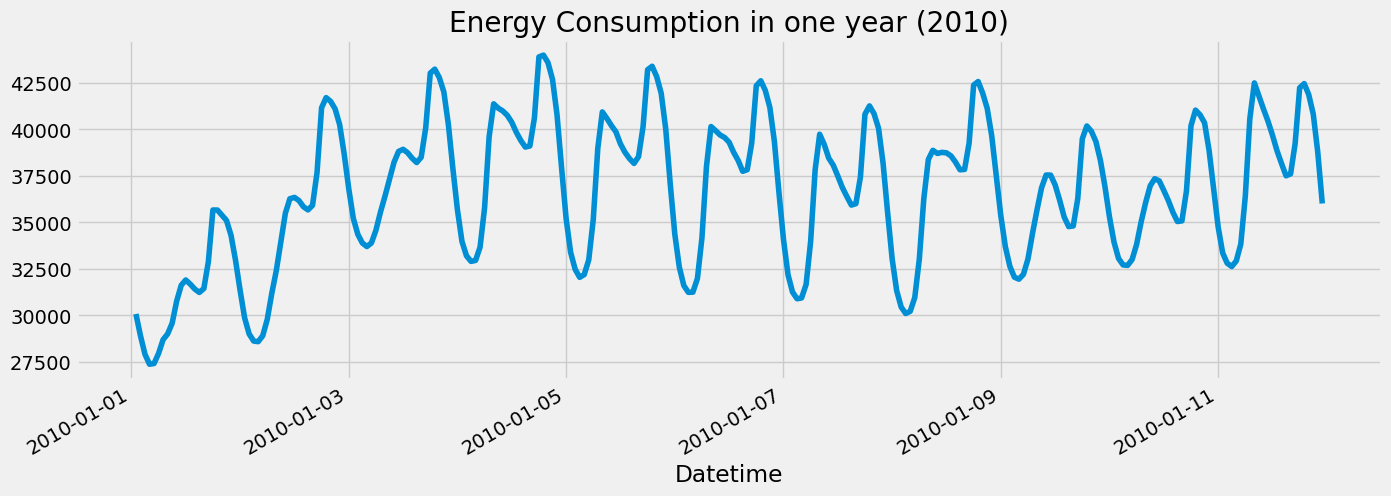

In [71]:
df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-12')]['COMED_MW'] \
    .plot(figsize=(15, 5), title='Energy Consumption in one year (2010)')

plt.show()

- Our data has seasonality.
- Daily peak/highest is around 6 PM and the mininum is at 4 AM
- Least energy consumption on weekends (Saturday/Sunday)
- The highest energy consumption in a year is either in the end of the year or in the middle of the year
- No significant trend or change in total energy consumption throughout the year 2002-2018
- Highest energy consumption in summer, then winter

# **5. Modeling Univariate Time Series**

In [72]:
univariate_df = df.copy()
univariate_df.drop(['hour', 'dayofweek', 'quarter', 'month','year', 'dayofyear', 'dayofmonth', 'weekofyear', 'season'], axis = 1, inplace = True) 
univariate_df.head()

,COMED_MW
Datetime,
2002-12-31 01:00:00,26498
2002-12-31 02:00:00,25147
2002-12-31 03:00:00,24574
2002-12-31 04:00:00,24393
2002-12-31 05:00:00,24860


## Resample Data (Downsampling)

In [73]:
# Resample to daily frequency
univariate_df = univariate_df.resample('D').mean()
univariate_df.head()

,COMED_MW
Datetime,
2002-01-01,31080.739130
2002-01-02,34261.541667
2002-01-03,34511.875000
2002-01-04,33715.458333
2002-01-05,30405.125000


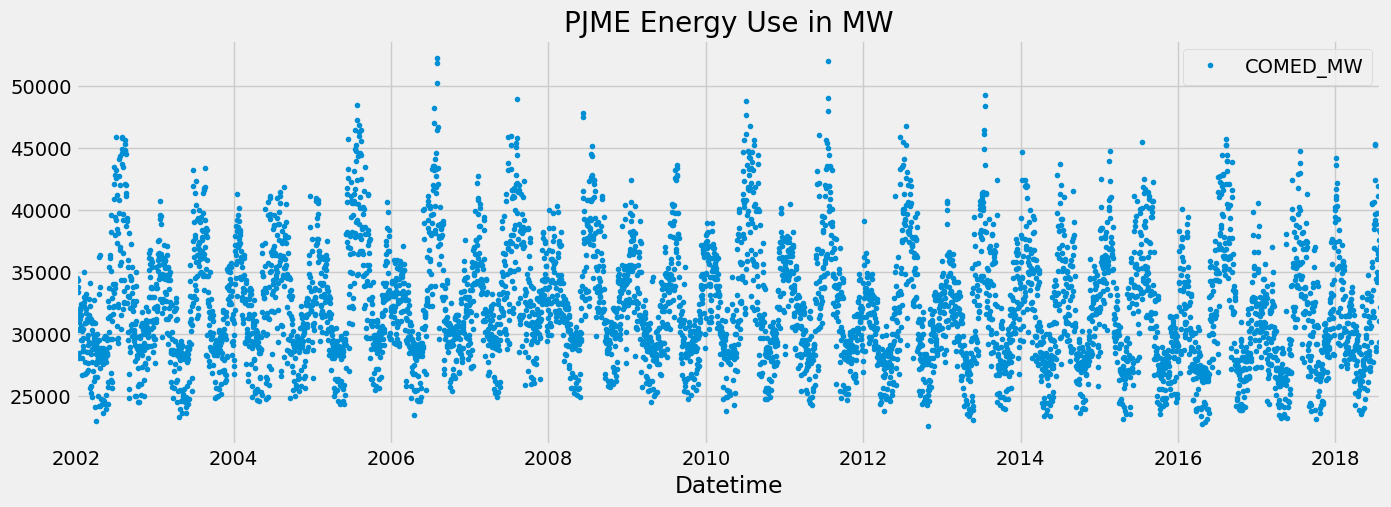

In [74]:
univariate_df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

## Divide Data into Train / Test

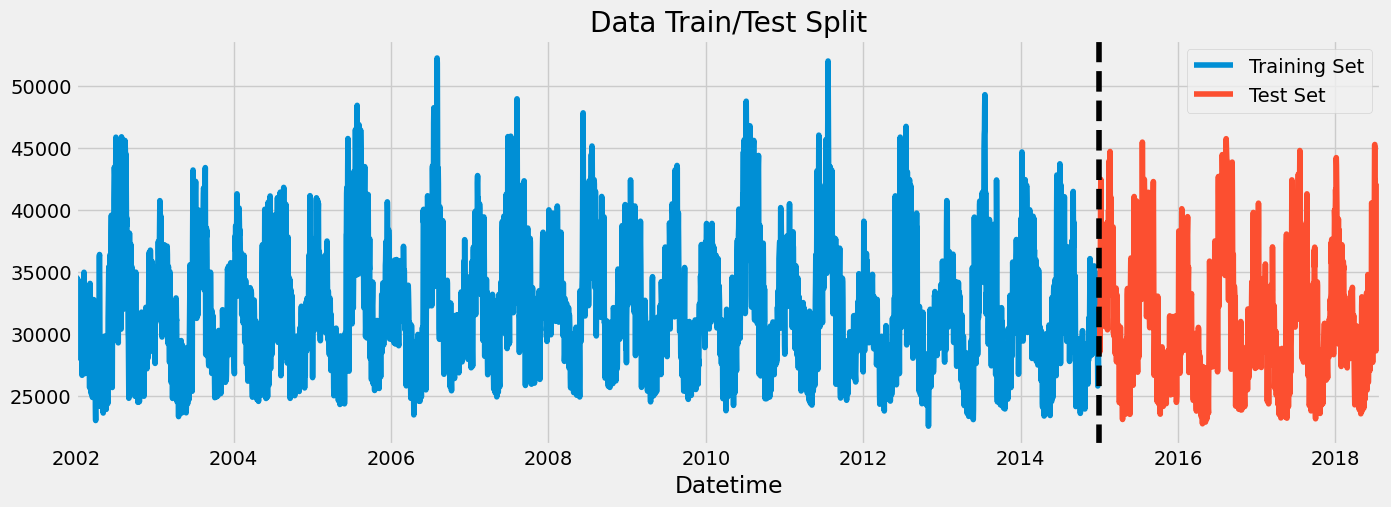

In [75]:
train = univariate_df.loc[univariate_df.index < '2015-01-01']
test = univariate_df.loc[univariate_df.index >= '2015-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train['COMED_MW'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['COMED_MW'].plot(ax=ax, label='Test Set')
ax.axvline('2015-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# **5.1 ARIMA**

## Steps to analyze ARIMA
- Step 1 — Check stationarity: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. .
- Step 2 — Difference: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
- Step 3 — Filter out a validation sample: This will be used to validate how accurate our model is. Use train test validation split to achieve this
- Step 4 — Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
- Step 5 — Build the model: Build the model and set the number of periods to forecast to N (depends on your needs).
- Step 6 — Validate model: Compare the predicted values to the actuals in the validation sample.

In [76]:
!pip install pmdarima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima

Defaulting to user installation because normal site-packages is not writeable


## Decompose time series to check for seasonality and trend

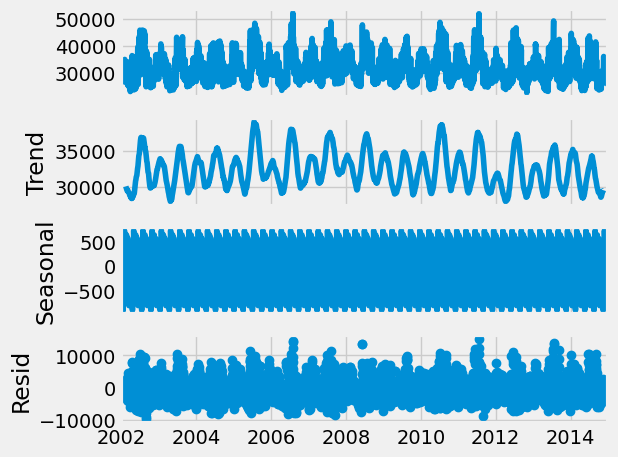

In [77]:
# Decompose time series
decompose = seasonal_decompose(train, model='additive', period=90)
decompose.plot()
plt.show()

### Very high seasonality! This is not ideal

## Check if the time series is stationary (Dickey-Fuller test)

In [78]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()

    # Plot rolling statistics:
    plt.figure(figsize=(15, 5))
    plt.plot(timeseries, color=color_pal[0], label='Original')
    plt.plot(rolmean, color=color_pal[1], label='Rolling Mean')
    plt.plot(rolstd, color=color_pal[2], label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

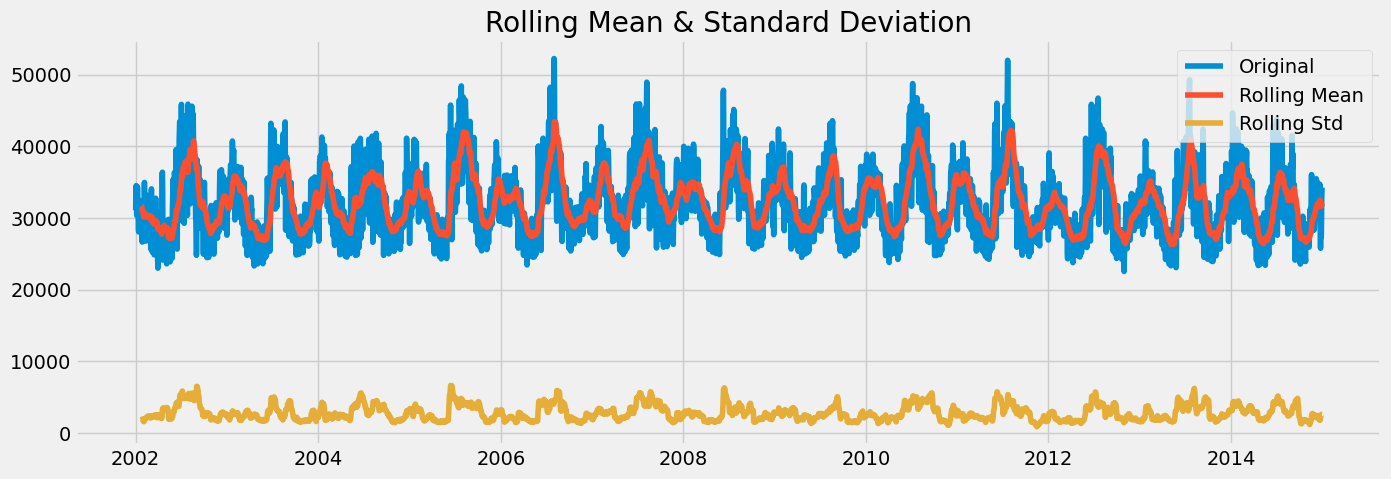

Results of Dickey-Fuller Test:
Test Statistic                -8.141113e+00
p-value                        1.027573e-12
#Lags Used                     3.000000e+01
Number of Observations Used    4.717000e+03
Critical Value (1%)           -3.431737e+00
Critical Value (5%)           -2.862153e+00
Critical Value (10%)          -2.567096e+00
dtype: float64


In [79]:
test_stationarity(train)

We use a rolling mean and standard deviation of 24 hours and plot these along with the original time series. If the rolling statistics do not change over time, it is an indication that the time series is stationary. We also perform the Dickey-Fuller test and check if the p-value is less than 0.05. If it is, we can reject the null hypothesis that the time series is non-stationary.

Based on the results of the Dickey-Fuller test, the p-value is less than 0.05, and we can reject the null hypothesis. Therefore, the time series is stationary.

## Plot the ACF and PACF (Select AR and MA terms)

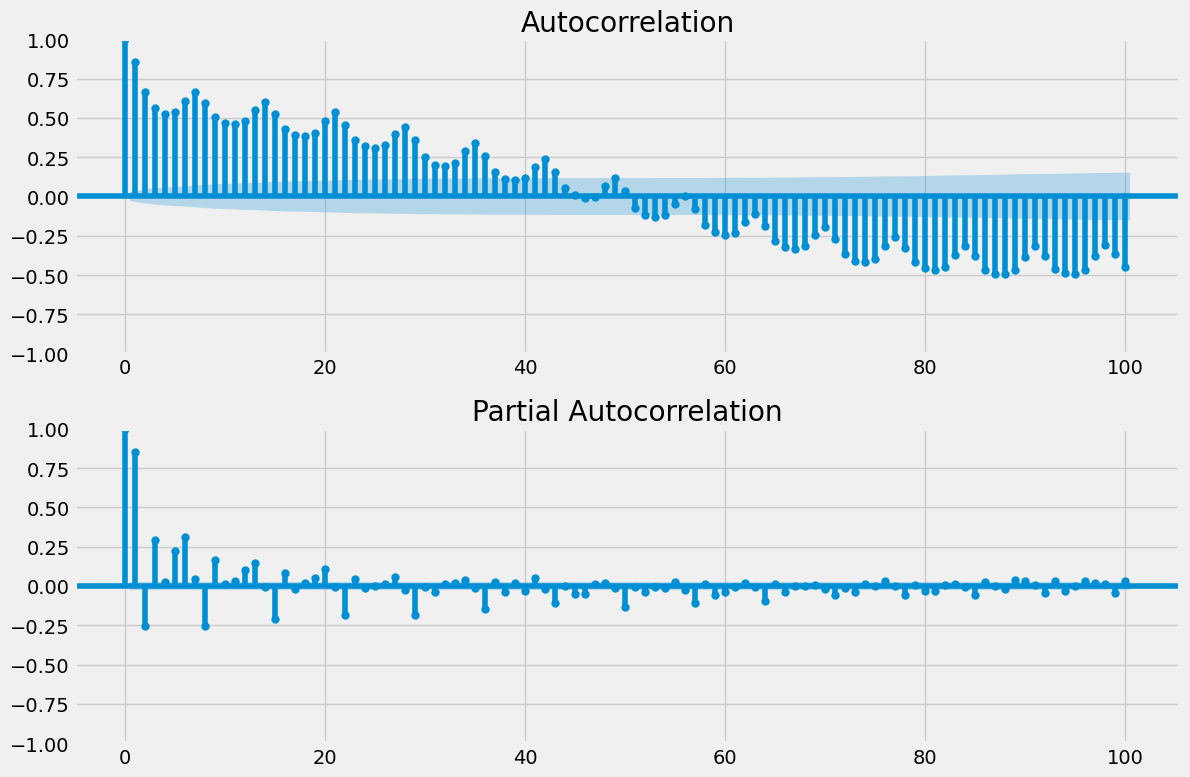

In [80]:
# ACF and PACF plots:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# Plot ACF
plot_acf(train, lags=100, ax=ax1)

# Plot PACF
plot_pacf(train, lags=100, ax=ax2)

plt.tight_layout()
plt.show()

## Build the Model

In [81]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(train, 
           start_p=0, start_q=0, max_p=10, max_q=10, 
           seasonal=True, m=7,
           d=None, D=None, trace=True, 
           error_action='ignore', suppress_warnings=True, 
           stepwise=True, seasonal_test='ch')

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=90712.791, Time=3.40 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=91549.953, Time=0.29 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=86213.508, Time=6.96 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=86938.647, Time=5.63 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=91547.963, Time=0.16 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=87510.621, Time=0.72 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=85700.698, Time=13.59 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=85104.787, Time=31.90 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=18.22 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=34.34 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=21.45 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=90705.185, Time=8.49 sec
 ARIMA(2,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=34.58 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=84496.276, Time=31.97 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   

In [82]:
# Fit the model
model = SARIMAX(train, 
                order=(1,0,1),
                seasonal_order=(2, 1, 1, 7),
                enforce_stationarity=False, 
                enforce_invertibility=False)

result = model.fit()
result.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96759D+00    |proj g|=  1.04244D-01

At iterate    5    f=  8.92980D+00    |proj g|=  6.26931D-02

At iterate   10    f=  8.91131D+00    |proj g|=  3.45786D-02

At iterate   15    f=  8.90934D+00    |proj g|=  1.76991D-03

At iterate   20    f=  8.90934D+00    |proj g|=  5.72570D-04

At iterate   25    f=  8.90925D+00    |proj g|=  9.86515D-03

At iterate   30    f=  8.90153D+00    |proj g|=  1.15422D-01

At iterate   35    f=  8.83813D+00    |proj g|=  4.38090D-02

At iterate   40    f=  8.83790D+00    |proj g|=  2.31707D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          COMED_MW   No. Observations:                 4748
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 7)   Log Likelihood              -41962.368
Date:                           Mon, 11 Dec 2023   AIC                          83936.735
Time:                                   17:42:15   BIC                          83975.500
Sample:                               01-01-2002   HQIC                         83950.360
                                    - 12-31-2014                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8329      0.007    115.306      0.000       0.819       0.847
ma.L1          0.3704      0.012     31.986      0.000       0.348       0.393
ar.S.L7        0.0611      0.012      4.924      0.000       0.037       0.085
ar.S.L14       0.0566      0.013      4.374      0.000       0.031       0.082
ma.S.L7       -0.9917      0.002   -402.031      0.000      -0.997      -0.987
sigma2      2.933e+06   4.29e+04     68.427      0.000    2.85e+06    3.02e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):               789.25
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.23
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
# Predict on the test data
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start, end, typ = 'levels').rename("Predictions")

/home/students/mgharpur/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


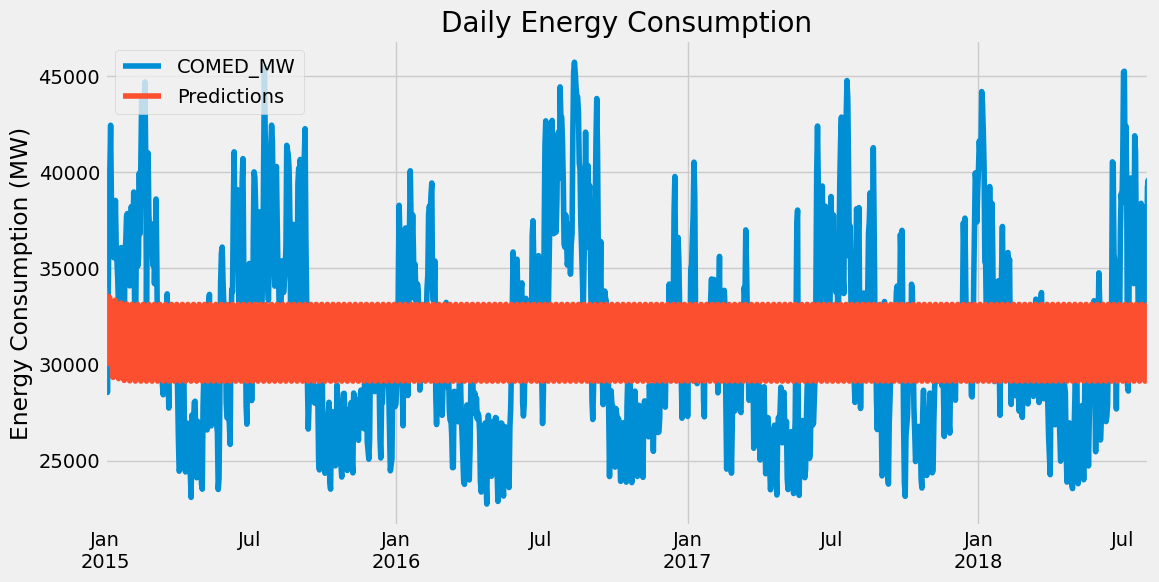

In [84]:
# Plot predictions against known values
title = 'Daily Energy Consumption'
ylabel='Energy Consumption (MW)'
xlabel='' 

ax = test['COMED_MW'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()

Because our data is showing multiple seasonalities, the (S)ARIMA model is not performing well.

## Score RMSE:

In [85]:
arima_rmse = mean_squared_error(test['COMED_MW'], predictions , squared=False)
arima_rmse

4681.897678936371

In [86]:
comparison = pd.concat([test, predictions], axis=1)
comparison_rounded = comparison.round(2)
comparison_rounded

,COMED_MW,Predictions
2015-01-01,31765.58,33971.77
2015-01-02,32141.17,33380.56
2015-01-03,32014.38,30882.74
2015-01-04,28542.29,30046.91
2015-01-05,33176.12,33031.20
...,...,...
2018-07-30,32957.42,32266.95
2018-07-31,34539.08,32978.36
2018-08-01,39230.79,33123.69
2018-08-02,39593.04,32854.09


# 3.2 Prophet

In [87]:
from prophet import Prophet

# Format data for prophet model using ds and y
pjme_train_prophet = train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'COMED_MW':'y'})

In [88]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

17:42:31 - cmdstanpy - INFO - Chain [1] start processing
17:42:31 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 542 ms, sys: 6.19 ms, total: 548 ms
Wall time: 1.45 s


In [89]:
# Predict on test set with model
pjme_test_prophet = test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'COMED_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [90]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,31258.394640,28928.394666,35941.988759,31258.394640,31258.394640,1206.378522,1206.378522,1206.378522,1079.323656,1079.323656,1079.323656,127.054866,127.054866,127.054866,0.0,0.0,0.0,32464.773162
1,2015-01-02,31257.763374,28641.273139,35582.929471,31257.763374,31257.763374,770.653368,770.653368,770.653368,600.432050,600.432050,600.432050,170.221318,170.221318,170.221318,0.0,0.0,0.0,32028.416742
2,2015-01-03,31257.132108,25949.070085,32717.095035,31257.132108,31257.132108,-1767.618459,-1767.618459,-1767.618459,-2005.357658,-2005.357658,-2005.357658,237.739199,237.739199,237.739199,0.0,0.0,0.0,29489.513649
3,2015-01-04,31256.500842,25124.924617,32451.615643,31256.500842,31256.500842,-2442.470093,-2442.470093,-2442.470093,-2771.468017,-2771.468017,-2771.468017,328.997924,328.997924,328.997924,0.0,0.0,0.0,28814.030749
4,2015-01-05,31255.869576,28925.662570,35819.880599,31255.869576,31255.869576,1053.870864,1053.870864,1053.870864,611.038808,611.038808,611.038808,442.832056,442.832056,442.832056,0.0,0.0,0.0,32309.740440


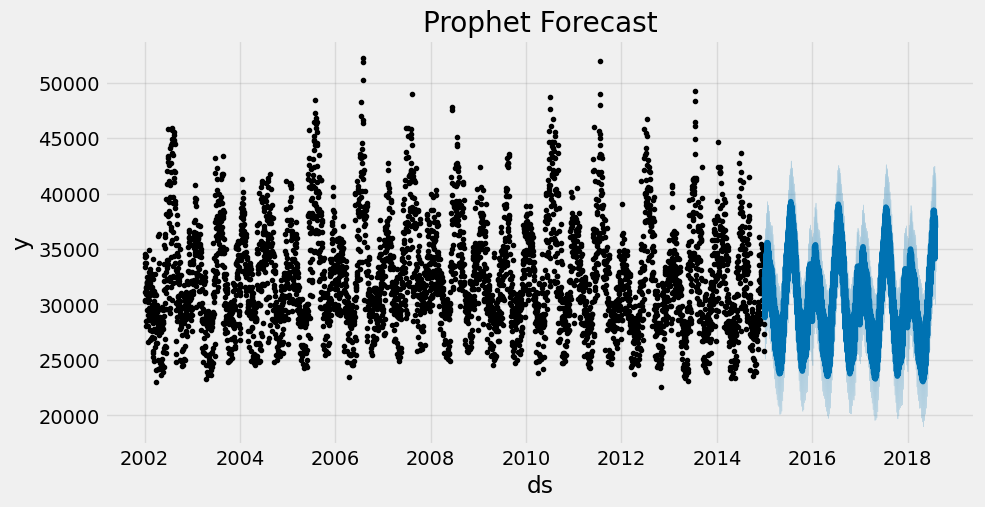

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

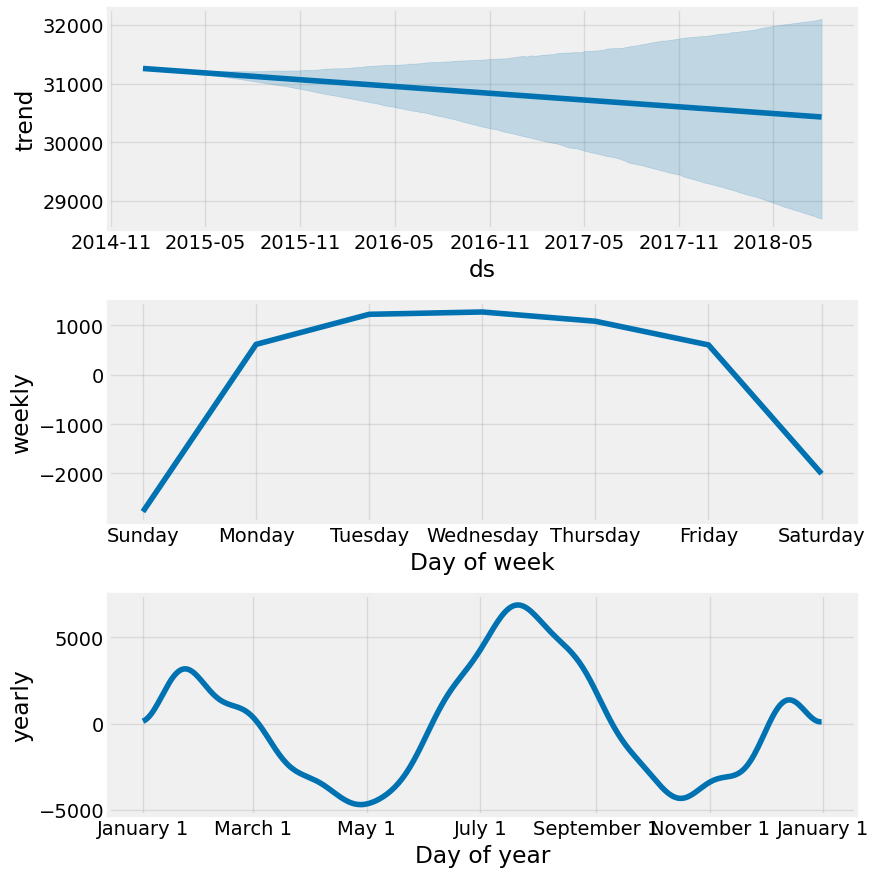

In [92]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

## Compare Forecast to Actuals

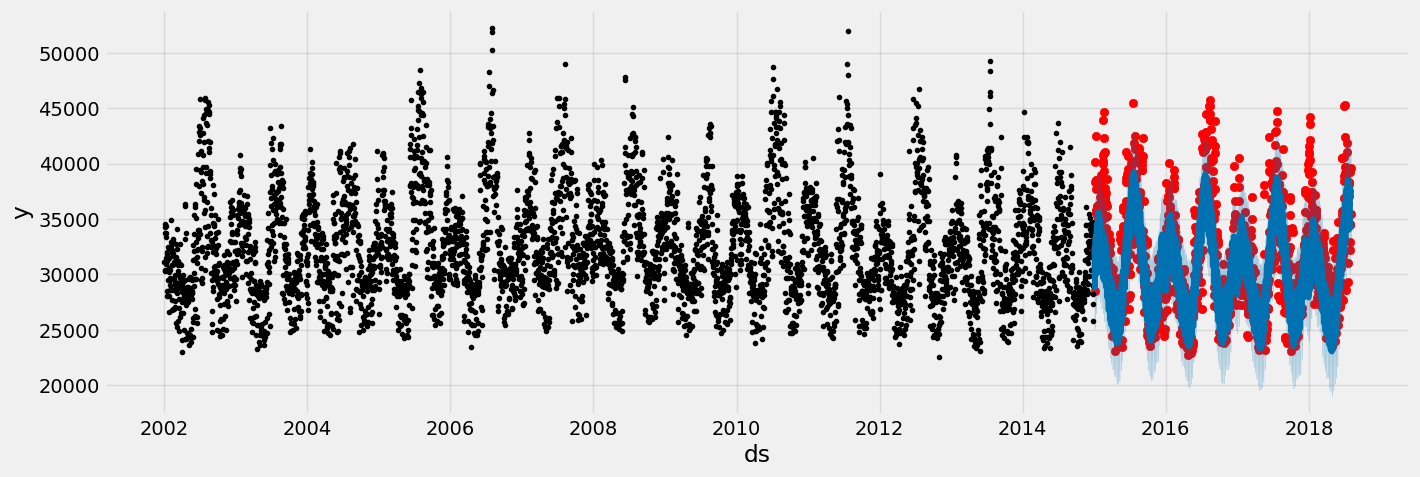

In [93]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['COMED_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

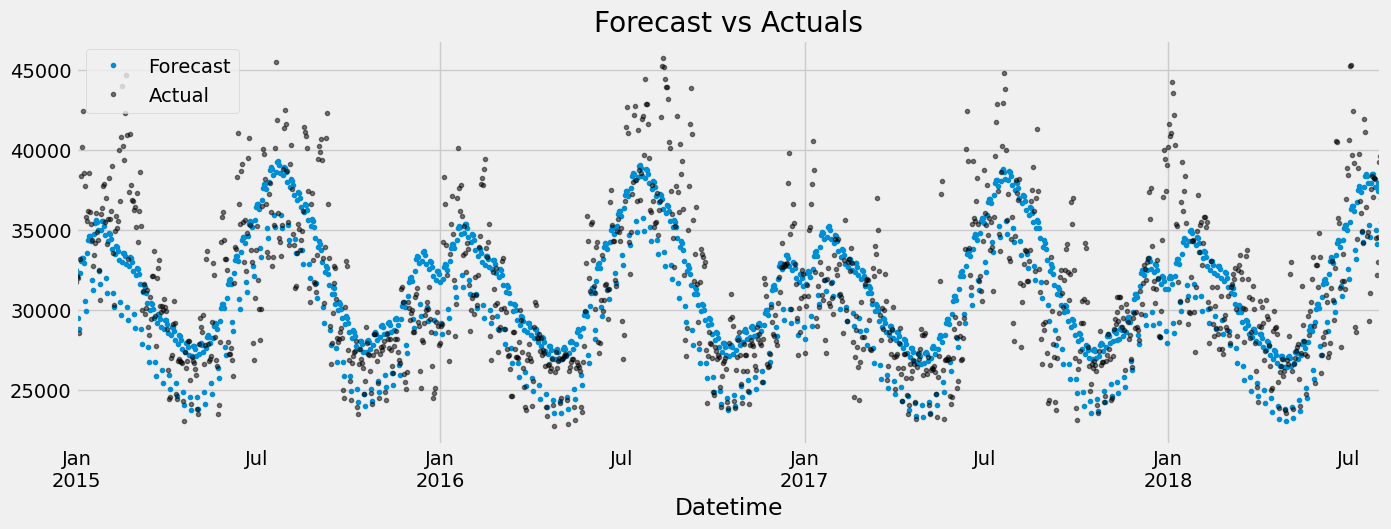

In [94]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
test['COMED_MW'].plot(ax=ax,
                          style='.',
                          lw=1,
                          alpha=0.5,
                          color = "black")

plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

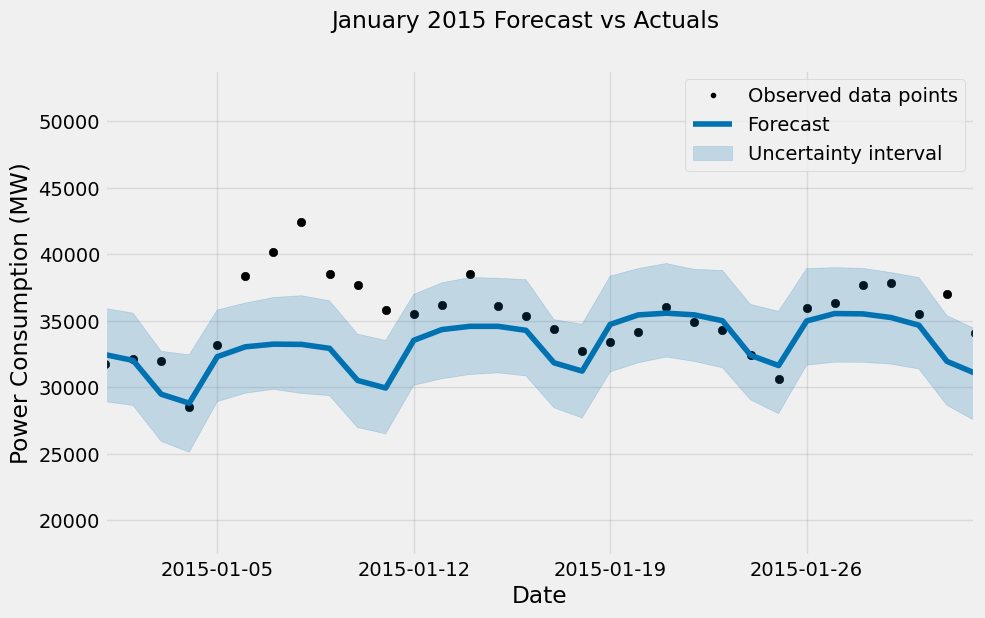

In [95]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(test.index, test['COMED_MW'], color='black')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2015-02-01'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption (MW)')
plot = plt.suptitle('January 2015 Forecast vs Actuals')

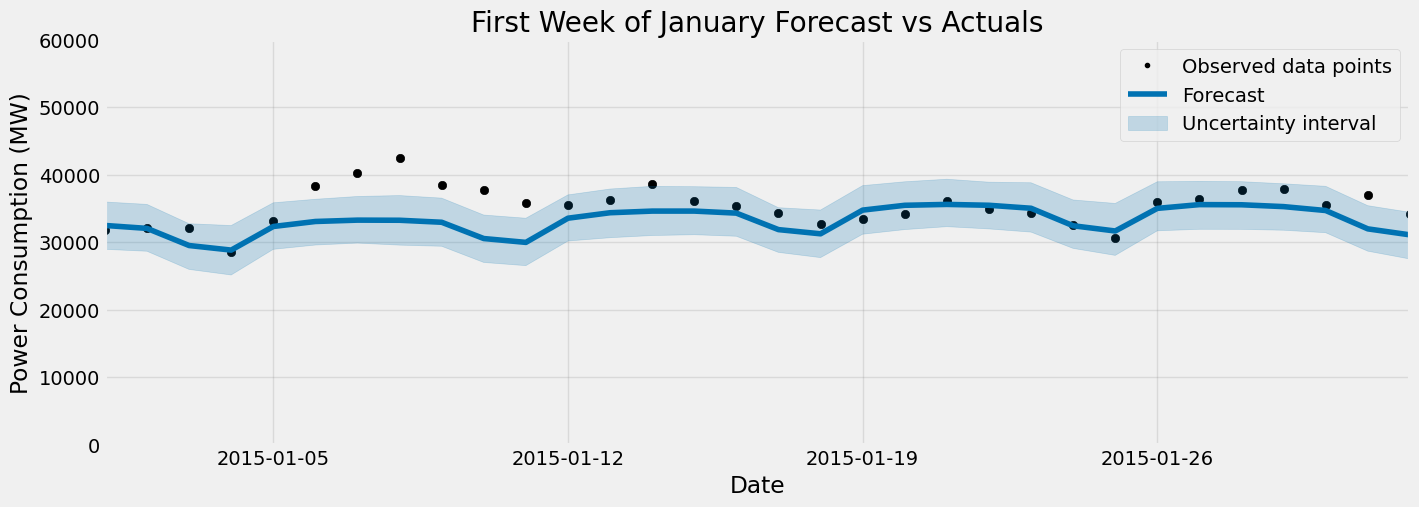

In [96]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['COMED_MW'], color='black')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2015-02-01'))
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption (MW)')
plt.show()

## Score RMSE

In [97]:
prophet_rmse= mean_squared_error(y_true=test['COMED_MW'], y_pred=pjme_test_fcst['yhat'], squared=False)
prophet_rmse

3269.176617463259

## Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [98]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=train.index.min(),
                              end=train.index.max())
test_holidays = cal.holidays(start=test.index.min(),
                             end=test.index.max())

In [99]:
# Create a dataframe with holiday, ds columns
df['date'] = df.index.date
df['is_holiday'] = df.date.isin([d.date() for d in cal.holidays()])
holiday_df = df.loc[df['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['COMED_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,holiday
0,2003-01-01 00:00:00,0,2,1,1,2003,1,1,1,Winter,USFederalHoliday
1,2002-12-25 01:00:00,1,2,4,12,2002,359,25,52,Winter,USFederalHoliday
2,2002-12-25 02:00:00,2,2,4,12,2002,359,25,52,Winter,USFederalHoliday
3,2002-12-25 03:00:00,3,2,4,12,2002,359,25,52,Winter,USFederalHoliday
4,2002-12-25 04:00:00,4,2,4,12,2002,359,25,52,Winter,USFederalHoliday


In [100]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [101]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'COMED_MW':'y'}))

17:42:43 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1] done processing


## Predict with holiday

In [102]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

## Plot Holiday Effect

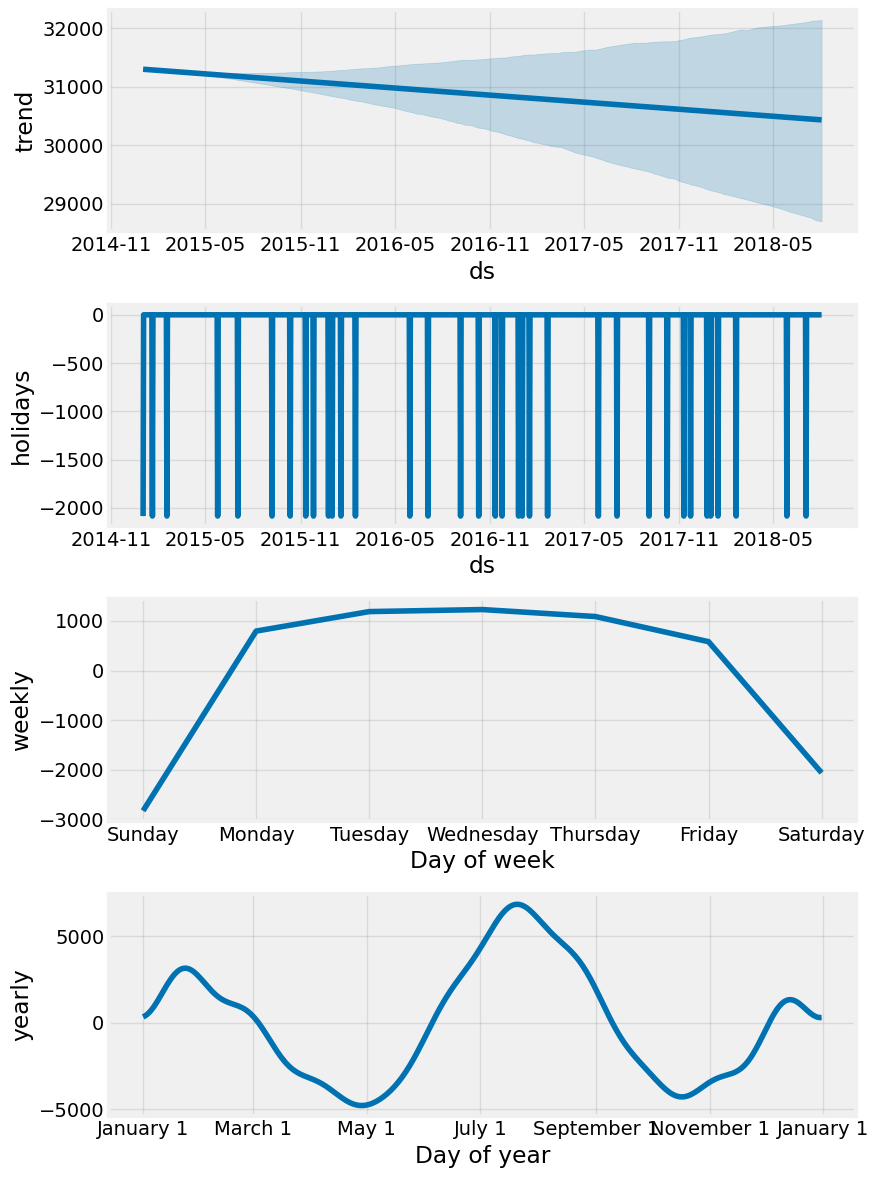

In [103]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

## Score RMSE with Holidays:

In [104]:
prophet_rmse_holidays = mean_squared_error(y_true=test['COMED_MW'], y_pred=pjme_test_fcst_with_hols['yhat'], squared=False)
print(f"RMSE with holidays: {prophet_rmse_holidays}")
print(f"RMSE without holidays: {prophet_rmse}")

RMSE with holidays: 3266.0348606564557
RMSE without holidays: 3269.176617463259


In [105]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = pjme_test_fcst.query('ds in @holiday_list')
    hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['COMED_MW'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['COMED_MW'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: January 01, 2015:    
 MAE (non-holiday model): 699.2 
 MAE (Holiday Model): 1138.9 
 Diff -439.7
Holiday: January 19, 2015:    
 MAE (non-holiday model): 1309.0 
 MAE (Holiday Model): 552.6 
 Diff 756.4
Holiday: February 16, 2015:    
 MAE (non-holiday model): 10960.5 
 MAE (Holiday Model): 12783.5 
 Diff -1823.0
Holiday: May 25, 2015:    
 MAE (non-holiday model): 1307.4 
 MAE (Holiday Model): 491.6 
 Diff 815.8
Holiday: July 03, 2015:    
 MAE (non-holiday model): 6271.3 
 MAE (Holiday Model): 4249.9 
 Diff 2021.3
Holiday: September 07, 2015:    
 MAE (non-holiday model): 1542.5 
 MAE (Holiday Model): 3365.9 
 Diff -1823.4
Holiday: October 12, 2015:    
 MAE (non-holiday model): 895.0 
 MAE (Holiday Model): 910.8 
 Diff -15.8
Holiday: November 11, 2015:    
 MAE (non-holiday model): 1610.2 
 MAE (Holiday Model): 414.1 
 Diff 1196.1
Holiday: November 26, 2015:    
 MAE (non-holiday model): 4466.4 
 MAE (Holiday Model): 2520.0 
 Diff 1946.4
Holiday: December 25, 2015:    
 MA

## Predict into the Future
We can use the built in make_future_dataframe method to build our future dataframe and make predictions.

In [106]:
future = model.make_future_dataframe(periods=365*24*5, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [107]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2014-12-31 01:00:00,32846.912922
1,2014-12-31 02:00:00,32860.956448
2,2014-12-31 03:00:00,32873.490467
3,2014-12-31 04:00:00,32884.303913
4,2014-12-31 05:00:00,32893.218165


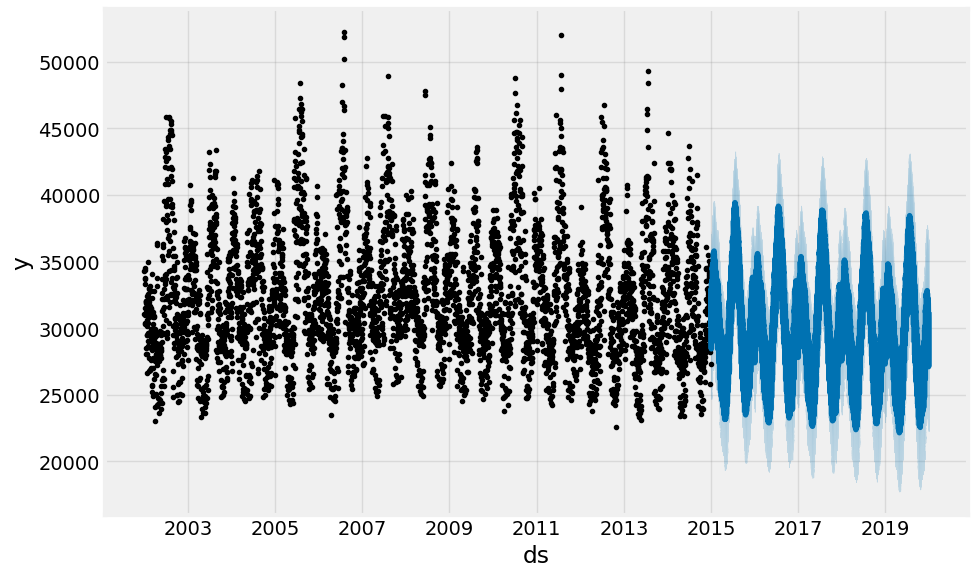

In [108]:
fig = model_with_holidays.plot(forecast)
plt.show()

# 4. Comparison of Models

In [109]:
print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"Prophet RMSE: {prophet_rmse:.2f}")

ARIMA RMSE: 4681.90
Prophet RMSE: 3269.18


# Takeaways

### ARIMA (Autoregressive Integrated Moving Average):
ARIMA models are a staple in time series forecasting. They are designed to capture autocorrelation in the data, or in other words, the idea that future data points are related to past ones.

##### Advantages:

- simple and interpretable parameters
- less tuning needed compared to machine learning models

##### Disadvantages:

- requires stationary data
- struggles with multiple seasonal patterns
- computationally intensive for large datasets

### Prophet:
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

##### Advantages:

- handles multiple seasonalities well
- flexible with inclusion of holiday effects and additional regressors
- easy to use (does not require a deep understanding of its underlying implementations)

##### Disadvantages:

- components of the forecast are not easily interpretable as those in ARIMA
- less Effective on High Frequency Data (e.g., data collected every minute or every second)